In [62]:
####################################
#ENVIRONMENT SETUP

In [63]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import xarray as xr

import sys; import os; import time; from datetime import timedelta
import pickle
import h5py
from tqdm import tqdm

In [64]:
#MAIN DIRECTORIES
def GetDirectories():
    mainDirectory='/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/'
    mainCodeDirectory=os.path.join(mainDirectory,"Code/CodeFiles/")
    scratchDirectory='/mnt/lustre/koa/scratch/air673/'
    codeDirectory=os.getcwd()
    return mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory

[mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory] = GetDirectories()

In [65]:
#IMPORT CLASSES
sys.path.append(os.path.join(mainCodeDirectory,"2_Variable_Calculation"))
from CLASSES_Variable_Calculation import ModelData_Class, SlurmJobArray_Class, DataManager_Class

In [66]:
#IMPORT FUNCTIONS
sys.path.append(os.path.join(mainCodeDirectory,"2_Variable_Calculation"))
import FUNCTIONS_Variable_Calculation
from FUNCTIONS_Variable_Calculation import *

In [67]:
#data loading class
ModelData = ModelData_Class(mainDirectory, scratchDirectory, simulationNumber=1)
#data manager class
DataManager = DataManager_Class(mainDirectory, scratchDirectory, ModelData.res, ModelData.t_res, ModelData.Nz_str,
                                ModelData.Np_str, dataType="Tracking_Algorithms", dataName="Lagrangian_UpdraftTracking",
                                dtype='float32',codeSection = "Project_Algorithms")

=== CM1 Data Summary ===
 Simulation #:   1
 Resolution:     1km
 Time step:      5min
 Vertical levels:34
 Parcels:        1e6
 Data file:      /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_1km_5min_34nz.nc
 Parcel file:    /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_pdata_1km_5min_1e6np.nc
 Time steps:     133

=== DataManager Summary ===
 inputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData
 outputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Project_Algorithms/Tracking_Algorithms
 inputDataDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData/1km_5min_34nz/ModelData
 inputParcelDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/D

In [68]:
#data manager class (for saving data)
DataManager_TrackedProfiles = DataManager_Class(mainDirectory, scratchDirectory, ModelData.res, ModelData.t_res, ModelData.Nz_str,
                                ModelData.Np_str, dataType="Tracked_Profiles", dataName="Tracked_Profiles",
                                dtype='float32',codeSection = "Project_Algorithms")

=== DataManager Summary ===
 inputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData
 outputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Project_Algorithms/Tracked_Profiles
 inputDataDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData/1km_5min_34nz/ModelData
 inputParcelDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData/1km_5min_34nz/ParcelData
 outputDataDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Project_Algorithms/Tracked_Profiles/1km_5min_34nz/Tracked_Profiles



In [69]:
#IMPORT CLASSES
sys.path.append(os.path.join(mainCodeDirectory,"3_Project_Algorithms","2_Tracking_Algorithms"))
from CLASSES_TrackingAlgorithms import TrackingAlgorithms_DataLoading_Class, Results_InputOutput_Class, TrackedParcel_Loading_Class

In [70]:
# IMPORT CLASSES
sys.path.append(os.path.join(mainCodeDirectory,"3_Project_Algorithms","3_Tracked_Profiles"))
from CLASSES_TrackedProfiles import TrackedProfiles_DataLoading_CLASS

In [71]:
##############################################
#JOB ARRAY

In [72]:
#JOB ARRAY SETUP
UsingJobArray=True

def GetNumJobs(res):
    if res=='1km':
        num_jobs=20
    elif res=='250m': 
        num_jobs=100
    return num_jobs
num_jobs = GetNumJobs(ModelData.res)
SlurmJobArray = SlurmJobArray_Class(total_elements=ModelData.Ntime, num_jobs=num_jobs, UsingJobArray=UsingJobArray)
start_job = SlurmJobArray.start_job; end_job = SlurmJobArray.end_job

def GetNumElements():
    num_elements = np.arange(ModelData.Ntime)[start_job:end_job]
    return num_elements
num_elements = GetNumElements()

Running timesteps from 0:6 



In [73]:
##############################################
#DATA LOADING FUNCTIONS

In [74]:
def MakeDataDictionary(variableNames,t,printstatement=False):
    timeString = ModelData.timeStrings[t]
    # print(f"Getting data from {timeString}","\n")
    
    dataDictionary = {variableName: CallLagrangianArray(ModelData, DataManager, timeString, variableName=variableName, printstatement=printstatement) 
                      for variableName in variableNames}      
    return dataDictionary
    
def GetSpatialData(t):    
    variableNames = ['Z','Y','X']
    dataDictionary = MakeDataDictionary(variableNames,t)
    [Z,Y,X] = (dataDictionary[k] for k in variableNames)
    return Z,Y,X

def GetLangrangianBinaryArray(t):
    variableNames=['PROCESSED_A_g','PROCESSED_A_c']
    binaryDictionary = MakeDataDictionary(variableNames,t)
    
    A_g = binaryDictionary['PROCESSED_A_g']
    A_c = binaryDictionary['PROCESSED_A_c']

    return A_g,A_c

In [75]:
########################################
#RUNNING FUNCTIONS

In [123]:
#Functions for Initializing Profile Arrays
def CopyStructure(dictionary, placeholder=None):
    """Deep-copy dictionary structure, replacing leaves with a given placeholder."""
    if isinstance(dictionary, dict):
        return {k: CopyStructure(v, placeholder) for k, v in dictionary.items()}
    else:
        return placeholder

def InitializeHistograms(trackedArrays, varNames, time_bins, property_bins_Dictionary):
    """
    Create a nested structure matching trackedArrays,
    with empty histogram arrays for each variable:
        - var_hist2d
        - var_parcel_last_time_hist2d
    """
    
    histogramsDictionary = {}
    n_time = len(time_bins) - 1
    
    for category, depth_dict in trackedArrays.items():  # e.g. 'CL', 'SBF'
        histogramsDictionary[category] = {}

        for depth_type in depth_dict.keys():  # e.g. 'ALL', 'SHALLOW', 'DEEP'
            histogramsDictionary[category][depth_type] = {}

            for varName in varNames:

                # number of property bins for this variable
                n_prop = len(property_bins_Dictionary[varName]) - 1

                # initialize empty histograms
                histogramsDictionary[category][depth_type][f"{varName}_hist2d"] = \
                    np.zeros((n_time, n_prop))

                histogramsDictionary[category][depth_type][f"{varName}_parcel_last_time_hist2d"] = \
                    np.zeros((n_time, n_prop))
    return histogramsDictionary

In [124]:
def GetParcelNumbers(trackedArray, t):
    """
    Return all parcel indices (p) and their corresponding row indices
    for parcels that are active at time t.
    Vectorized, no row-by-row loops.
    """
    t_start = trackedArray[:, 1]
    t_end   = np.minimum(trackedArray[:, 2] + trackedArray[:, 3], ModelData.Ntime)

    # Boolean mask for rows active at time t
    mask = (t >= t_start) & (t <= t_end)

    # Extract parcel numbers and their corresponding row indices
    selectedRows = np.where(mask)[0]
    selectedPs = trackedArray[selectedRows, 0]
    leftRightIndexes = trackedArray[selectedRows, 4]

    return selectedRows, selectedPs, leftRightIndexes

In [149]:
def MakeTrackedProfiles(trackedArrays,histogramsDictionary,property_bins_Dictionary,varNames,Z,Y,X,t, A_g,A_c,A_g_Prior,A_c_Prior):
    """
    Update profileArraysDictionary with variable data for parcels active at time t.
    Accumulates sums and counts in both profile_array and profile_array_squares.
    """
    #CALCULATING
    for key1, subdict in trackedArrays.items():         # e.g. 'CL', 'SBF'
        print("\t",f'working on {key1}')
        for key2, trackedArray in subdict.items():           # e.g. 'ALL', 'DEEP'
            print("\t\t",f'working on {key2}')
    
            #getting parcels in trackedArray to run through
            _, selectedPs, leftRightIndexes = GetParcelNumbers(trackedArray, t) #get parcels that are counted at time t
            
            #getting Z data
            zLevels = Z[selectedPs]
            yLevels = Y[selectedPs]
            xLevels = X[selectedPs]

            #find which other parcels exist in each grid box
            # Step 1: compute spatial matches once
            gridboxMatches = [
                np.where((Z == zLevel) & (Y == yLevel) & (X == xLevel))[0]
                for zLevel, yLevel, xLevel in zip(zLevels, yLevels, xLevels)
            ]

            #find which of those parcels were entrained into a general/cloudy updraft
            
            # Step 2: compute entrainment masks
            mask_c = A_c & (~A_c_Prior)
            
            # Step 3: apply masks to find all parcels
            whereOtherEntrainedParcels_c = [
                idx[mask_c[idx]]
                for idx in gridboxMatches
            ]

            # Step 4: collapsing list of all found parcels
            collapsed = np.concatenate(whereOtherEntrainedParcels_c)

            # Step 5: track parcels back (last 30 minutes) and read properties
            # property_bins = Dictionary of bins for each variable (predetermined)#*

            #GETTING LAST TIME PARCEL IN CLOUD
            last_cloud_time = np.full(len(collapsed), np.nan)
            last_property_value = {varName: np.full(len(collapsed), np.nan) for varName in varNames}
            
            trackTimes = np.arange(t,(t-timesteps_per_hour)-1,-1)
            for count, t_back in enumerate(trackTimes):
                relative_time = t_back - t

                VARs = MakeDataDictionary(varNames, t_back)   

                for varName, array in VARs.items():
                    #GETTING PROPERTY HISTOGRAMS
                    ##########
                    # property values at this time for these entrained parcels
                    properties = array[collapsed]
            
                    # time arrays for histogram2d
                    times = np.full(properties.shape, relative_time)

                    # 2D histograms (time × property)
                    property_bins = property_bins_Dictionary[varName]
                    property_hist2d, _, _ = np.histogram2d(
                        times,
                        properties,
                        bins=(time_bins, property_bins)
                    )
                    
                    # ==> Make sure the dictionary has the varName keys in it #*
                    histogramsDictionary[key1][key2][f"{varName}_hist2d"] += property_hist2d
                    ##########
            
            #     #GETTING LAST TIME PARCEL IN CLOUD #*#*
            #     ##########
            #     if count > 0:
            #         # QCQI/QV for all entrained parcels
            #         qcqi_values = VARs["QCQI"][collapsed]

            #         # Which parcels currently in cloud
            #         in_cloud_now = (qcqi_values >= qcqi_thresh)
                    
            #         # Which parcels have NOT been assigned a last-cloud-time yet
            #         not_recorded = np.isnan(last_cloud_time)
            #         # Newly identified parcels whose LAST cloud time is t_back
            #         new_cloud_hits = in_cloud_now & not_recorded

            #         # Update the last-cloud-time + QV at that time
            #         last_cloud_time[new_cloud_hits] = relative_time
            #         for varName, array in VARs.items():
            #             property_values = array[collapsed]
            #             last_property_value[varName][new_cloud_hits] = property_values[new_cloud_hits]
            #     ##########

            # # GETTING LAST TIME PARCEL IN CLOUD
            # ##########
            # valid = ~np.isnan(last_cloud_time)

            # for varName in varNames:
            #     property_values = last_property_value[varName][valid]
            #     property_bins   = property_bins_Dictionary[varName]
                
            #     parcel_last_time_hist2d, _, _ = np.histogram2d(
            #         last_cloud_time[valid],
            #         property_values,
            #         bins=(time_bins, property_bins)
            #     )
            #     histogramsDictionary[key1][key2][f"{varName}_parcel_last_time_hist2d"] += parcel_last_time_hist2d
            #     ##########
            
            return histogramsDictionary #* testing
    return histogramsDictionary

In [180]:
########################################
#RUNNING

In [242]:
#Loading in Tracked Parcels Info
trackedArrays,LevelsDictionary = TrackedParcel_Loading_Class.LoadingSubsetParcelData(ModelData,DataManager,
                                                         Results_InputOutput_Class)

#needed parameters
timesteps_per_min = 1/(ModelData.time[1].item()/1e9/60 )
timesteps_per_hour = int(60*timesteps_per_min)
qcqi_thresh = 1e-6
# time_bins = np.arange(0,(0-timesteps_per_hour)-1,-1)[::-1]
time_bins = np.arange(0.5, -timesteps_per_hour-1.5, -1)[::-1]

#variables 
varNames = ["W","QV","QCQI","THETA_v"]

CL: ALL=12239, SHALLOW=8447, DEEP=369
nonCL: ALL=10043, SHALLOW=7614, DEEP=181
SBF: ALL=1905, SHALLOW=943, DEEP=139
ColdPool: ALL=10334, SHALLOW=7504, DEEP=230
Mean Cloudbase is: 1.45 km

Min Cloudbase is: 1.25 km

Mean LFC is: 1.93 km

Mean LCL is: 1.79 km

Min LFC is: 1.45 km

Min LCL is: 1.37 km



In [243]:
n_bins = 500
property_bins_Dictionary = {
    "W":     np.linspace(-5, 15, n_bins),         # vertical velocity bins
    "QV":    np.linspace(0, 20/1e3, n_bins),        # water vapor mixing ratio
    "QCQI":  np.linspace(1e-6, 3e-6, n_bins),         # cloud+ice mixing ratio
    "THETA_v":    np.linspace(300, 320, n_bins),       # potential temperature
}

In [256]:
##### #*testing (no separate saves and recombine)
#Forming Dictionary for Profile Arrays for current timestep
trackedProfileArrays = CopyStructure(trackedArrays)
histogramsDictionary = InitializeHistograms(trackedProfileArrays,varNames, time_bins,property_bins_Dictionary) #*

# for t in tqdm(num_elements, desc="Processing"):
for t in tqdm(range(100,110), desc="Processing"): #* testing
    print("#" * 40,"\n",f"Processing timestep {t}/{num_elements[-1]}")
    timeString = ModelData.timeStrings[t]

    # #Forming Dictionary for Profile Arrays for current timestep
    # trackedProfileArrays = CopyStructure(trackedArrays)
    # histogramsDictionary = InitializeHistograms(trackedProfileArrays,varNames, time_bins,property_bins_Dictionary) #*
    
    #getting variable data
    Z,Y,X = GetSpatialData(t)
    A_g,A_c = GetLangrangianBinaryArray(t)
    A_g_Prior,A_c_Prior = GetLangrangianBinaryArray(t-1)
    
    #making tracked profiles
    histogramDictionary = MakeTrackedProfiles(trackedArrays,histogramsDictionary,property_bins_Dictionary,varNames,Z,Y,X,t, A_g,A_c,A_g_Prior,A_c_Prior)
    if t == 110: break #* testing
    
    # #saving tracked profiles for current timestep
    # TrackedProfiles_DataLoading_CLASS.SaveProfile(ModelData,DataManager_TrackedProfiles, profileArraysDictionary, dataName, t)

Processing:   0%|          | 0/10 [00:00<?, ?it/s]

######################################## 
 Processing timestep 100/6
	 working on CL
		 working on ALL


Processing:  10%|█         | 1/10 [00:01<00:16,  1.82s/it]

######################################## 
 Processing timestep 101/6
	 working on CL
		 working on ALL


Processing:  20%|██        | 2/10 [00:04<00:17,  2.23s/it]

######################################## 
 Processing timestep 102/6
	 working on CL
		 working on ALL


Processing:  30%|███       | 3/10 [00:06<00:16,  2.32s/it]

######################################## 
 Processing timestep 103/6
	 working on CL
		 working on ALL


Processing:  40%|████      | 4/10 [00:08<00:13,  2.28s/it]

######################################## 
 Processing timestep 104/6
	 working on CL
		 working on ALL


Processing:  50%|█████     | 5/10 [00:11<00:11,  2.28s/it]

######################################## 
 Processing timestep 105/6
	 working on CL
		 working on ALL


Processing:  60%|██████    | 6/10 [00:13<00:08,  2.24s/it]

######################################## 
 Processing timestep 106/6
	 working on CL
		 working on ALL


Processing:  70%|███████   | 7/10 [00:15<00:06,  2.27s/it]

######################################## 
 Processing timestep 107/6
	 working on CL
		 working on ALL


Processing:  80%|████████  | 8/10 [00:18<00:04,  2.34s/it]

######################################## 
 Processing timestep 108/6
	 working on CL
		 working on ALL


Processing:  90%|█████████ | 9/10 [00:20<00:02,  2.31s/it]

######################################## 
 Processing timestep 109/6
	 working on CL
		 working on ALL


Processing: 100%|██████████| 10/10 [00:22<00:00,  2.28s/it]


In [ ]:
###############
#TEST PLOTTING

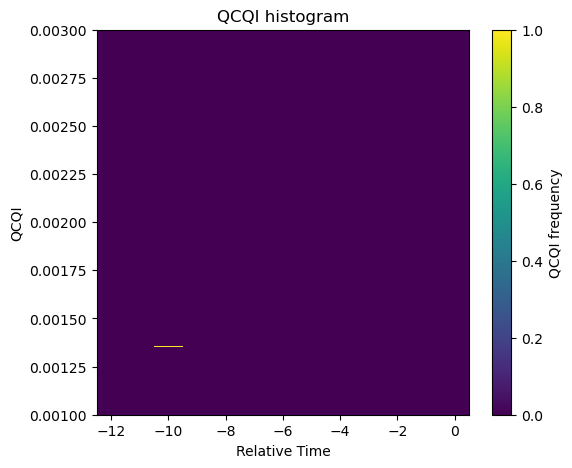

In [266]:
# varName = "W"
# varName = "QV"
varName = "QCQI"
# varName = "THETA_v"
a = histogramsDictionary["CL"]["ALL"][f"{varName}_hist2d"]

x = time_bins
y = property_bins_Dictionary[varName]

plt.figure(figsize=(6,5))
multiplier = 1e3 if varName in ["QV","QCQI"] else 1
plt.pcolormesh(x, multiplier*y, a.T, shading='auto')
plt.colorbar(label=f"{varName} frequency")
plt.xlabel("Relative Time")
plt.ylabel(varName)
plt.title(f"{varName} histogram")
plt.show()


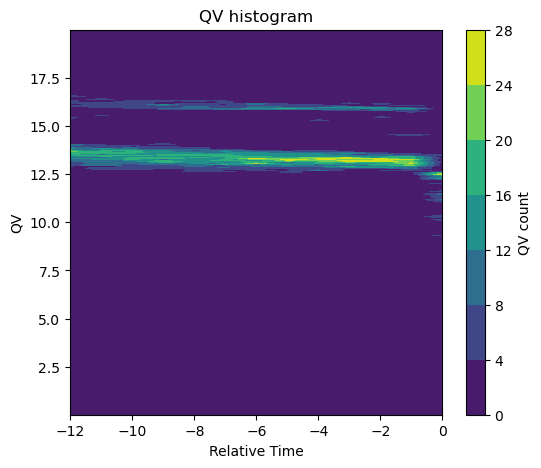

In [261]:
varName = "W"
varName = "QV"
# varName = "QCQI" #*
# varName = "THETA_v"
a = histogramsDictionary["CL"]["ALL"][f"{varName}_hist2d"]

x = time_bins
y = property_bins_Dictionary[varName]

x_centers = 0.5 * (x[:-1] + x[1:])
y_centers = 0.5 * (y[:-1] + y[1:])
X, Y = np.meshgrid(x_centers, y_centers)


plt.figure(figsize=(6,5))
multiplier = 1e3 if varName in ["QV","QCQI"] else 1
plt.contourf(X, multiplier*Y, a.T)
plt.colorbar(label=f"{varName} count")
plt.xlabel("Relative Time")
plt.ylabel(varName)
plt.title(f"{varName} histogram")
plt.show()


In [ ]:
#########################################
#RECOMBINE SEPERATE JOB_ARRAYS AFTER
recombine=False #KEEP FALSE WHEN JOBARRAY IS RUNNING
# recombine=True

In [ ]:
import copy
def RecombineProfiles(ModelData, DataManager):
    """
    Combine tracked profiles across all timesteps using the first as a template.
    """
    print(f"Recombining {ModelData.Ntime} TrackedProfiles files...\n")

    trackedProfileArrays = None

    for t in tqdm(range(ModelData.Ntime), desc="Combining Profiles", unit="timestep"):
        if dataName in ['Entrainment','PROCESSED_Entrainment'] and t == ModelData.Ntime-1:
            continue
        profileArraysDictionary = TrackedProfiles_DataLoading_CLASS.LoadProfile(ModelData, DataManager, dataName, t)

        if t == 0:
            # Deep copy structure so we don’t overwrite the first timestep’s data
            trackedProfileArrays = copy.deepcopy(profileArraysDictionary)
            continue  # move to next time step — skip accumulation for t=0

        # Add all later times to the initial one
        for key1 in profileArraysDictionary:
            for key2 in profileArraysDictionary[key1]:
                for varName in profileArraysDictionary[key1][key2]:
                    for arrayName in ["profile_array", "profile_array_squares",
                                      "profile_array_left", "profile_array_left_squares",
                                      "profile_array_right", "profile_array_right_squares"]:
                        trackedProfileArrays[key1][key2][varName][arrayName][:, 0:2] += (
                            profileArraysDictionary[key1][key2][varName][arrayName][:, 0:2]
                        )
    return trackedProfileArrays


In [ ]:
# if recombine==True:
#     for dataName in ["Variables",
#                      "Entrainment","PROCESSED_Entrainment",
#                      "W_Budgets","QV_Budgets","TH_Budgets"]:
#         print(f"Working on {dataName}")
#         trackedProfileArrays = RecombineProfiles(ModelData, DataManager_TrackedProfiles)
#         TrackedProfiles_DataLoading_CLASS.SaveProfile(ModelData,DataManager_TrackedProfiles, trackedProfileArrays, dataName, t='combined')

In [ ]:
##############################################
#LOADING BACK IN

In [ ]:
# profileArraysDictionary=TrackedProfiles_DataLoading_CLASS.LoadProfile(ModelData,DataManager_TrackedProfiles, dataName, t='combined')

In [ ]:
##############################################
#TESTING

In [ ]:
# #testing: comparing above vectorized version to multi-loop version below

# #pure calculation method (slow)
# t=80

# a = trackedArrays['CL']['DEEP']
# ps = a[:,0]
# t1s = a[:,1]
# t2s = a[:,2]+a[:,3]

# profile=np.zeros((ModelData.Nzh,3))
# profile[:,2] = ModelData.zh

# plen = len(ps)
# for count, (p,t1,t2) in enumerate(zip(ps,t1s,t2s)):
#     if count % 100 == 0: print(f"{count}/{plen}")
#     ts = np.arange(t1, t2+1)
    
#     for t_ in ts:
#         if t_ != t:
#             continue
#         Z = GetSpatialData(t)[p]
#         var = MakeDataDictionary(["W"], t=t)["W"][p]
#         profile[Z,0]+=var
#         profile[Z,1]+=1


# #plotting

# def Plot(a,color):
#     b= a[:,0]/a[:,1]
#     # b*=1000
#     plt.plot(b,a[:,2],color=color)
# one = profileArraysDictionary['CL']['DEEP']['W']['profile_array'] #created using MakeTrackedProfiles function
# two = profile.copy()
# Plot(one,color='black')
# Plot(two,color='blue') #plots are the same
# np.all(one[:,0]==two[:,0]) #=True